In [1]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from astropy.visualization import ImageNormalize, LogStretch
from matplotlib.colors import LogNorm
import os
import numpy as np
from astropy.io import fits
from censai import PhysicalModel

plt.style.use("science")
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)


In [17]:
data = fits.open(os.path.join(os.getenv("CENSAI_PATH2"), "data", "horseshoe_rim_data.fits"))
raw_observation = data["raw_observation"].data
observation = data["preprocessed_observation"].data
# lens_light = tf.constant(data["lens_light"], dtype=tf.float32)[None, ..., None]
rim_input = data["rim_input"].data
psf = data["psf"].data
noise_rms = data["PRIMARY"].header["noiserms"]
image_fov = data["PRIMARY"].header["fov"]
# src_fov = data["PRIMARY"].header["srcfov"]
src_fov = 2
# mask = data["mask"].data
# obs2 = data["galfit_observation"].data
phys = PhysicalModel(pixels=350, kappa_pixels=128, src_pixels=128, image_fov=image_fov, src_fov=src_fov, kappa_fov=image_fov)

In [18]:
hf = h5py.File(os.path.join(os.getenv("CENSAI_PATH2"), "results", f"horseshoe_50k_lr1e-7_dr1_lewc0.01_srcfov{src_fov}_RIMSU128hstv4_augmented_003_K3_L5_BCL2_211124140837_continue_lr6e-05_211129202839.h5"), "r")

In [19]:
source_pred = np.array(hf["source_best"])
kappa_pred = np.array(np.log10(hf["kappa_best"])) # took 10^x in script...
psf = np.array(psf)
y_pred = phys.forward(source_pred[None, ..., None], kappa_pred[None, ..., None], psf[None, ..., None])[0, ..., 0]

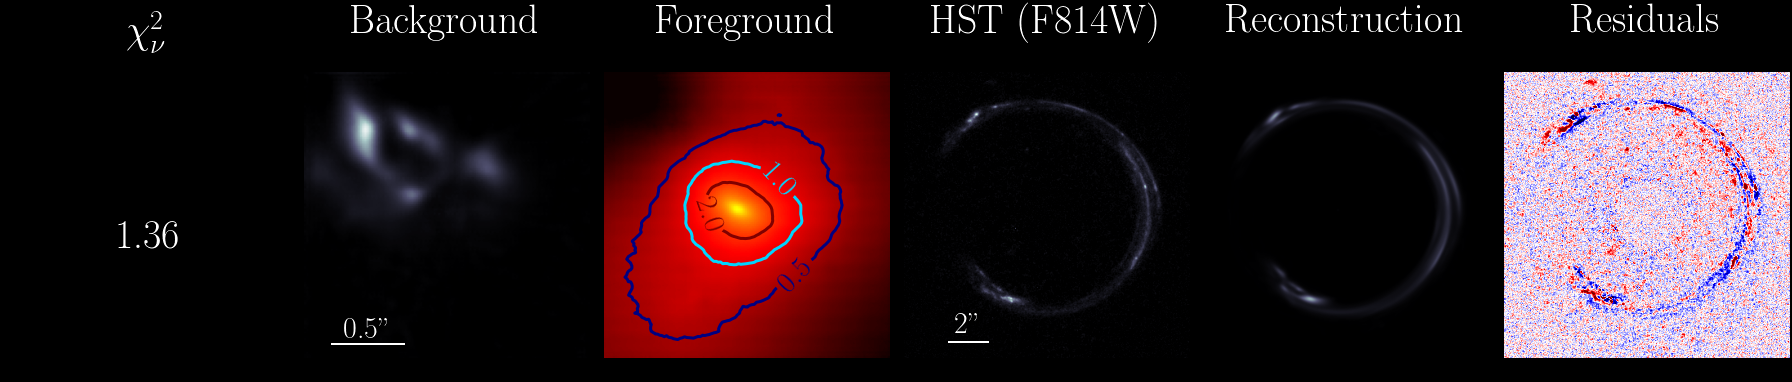

In [20]:
fig, axs = plt.subplots(1, 6, figsize=(32, 6), facecolor="k")

extent = [-image_fov/2, image_fov/2]*2
extent_src = [-src_fov/2, src_fov/2]*2

axs[0].annotate(f"{np.sum(((observation - y_pred)/noise_rms)**2 / 350**2):.2f}", xy=(0.4, 0.4), xycoords="axes fraction", size=40, color="w")

# axs[1].imshow(hf["source_best"], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1), origin="lower")
axs[1].imshow(source_pred, cmap="bone", vmin=0, vmax=1, origin="lower", extent=extent_src)

axs[2].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower", extent=extent) # took twice the function 10^x
# axs[2].imshow(raw_observation, cmap="bone", extent=extent, norm=ImageNormalize(stretch=LogStretch()), origin="lower")
levels = [0.5, 1, 2]
cs = axs[2].contour(kappa_pred, cmap="jet", levels=levels, linewidths=3, extent=extent) # took twice the function 10^x
axs[2].clabel(cs, levels, fontsize=30)

# axs[2].imshow(hf["kappa_pred"][300], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")

# axs[3].imshow(observation, cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-2, vmax=1), origin="lower")
axs[3].imshow(observation, cmap="bone", vmin=0, vmax=1, origin="lower", extent=extent)


# axs[4].imshow(y_pred, cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-2, vmax=1), origin="lower")
axs[4].imshow(y_pred, cmap="bone", vmin=0, vmax=1, origin="lower")

axs[5].imshow((observation - y_pred)/noise_rms, cmap="seismic", vmin=-5, vmax=5, origin="lower")

axs[5].set_title("Residuals", pad=40, fontsize=40, color="w")
axs[0].set_title(r"$\chi^2_\nu$", pad=0, fontsize=40, color="w")
axs[1].set_title(r"Background", pad=40, fontsize=40, color="w")
axs[2].set_title("Foreground", pad=40, fontsize=40, color="w")
axs[3].set_title("HST (F814W)", pad=40, fontsize=40, color="w")
axs[4].set_title("Reconstruction", pad=40, fontsize=40, color="w")

ax = axs[1]
#scale bar
p0 = -0.8
dist = 0.5
ax.plot([p0, p0 + dist], [-0.9, -0.9], linewidth=2, color="w")
ax.text(p0 + dist / 2., -0.85, "0.5''", fontsize=30, color="w", ha='center')

ax = axs[3]
#scale bar
p0 = -5
dist = 2
ax.plot([p0, p0 + dist], [-6.5, -6.5], linewidth=2, color="w")
ax.text(p0 + dist / 2., -6, "2''", fontsize=30, color="w", ha='center')


for i in range(6):
    axs[i].axis("off")
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig(f"horseshoe_pred{src_fov}.png", facecolor="k")

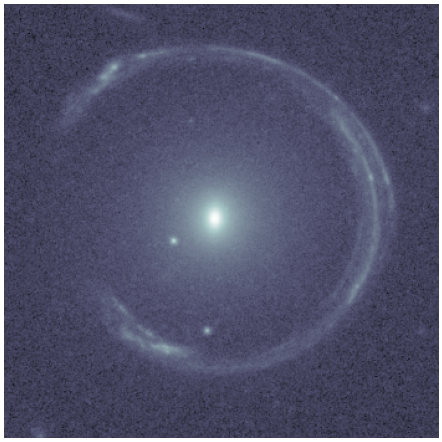

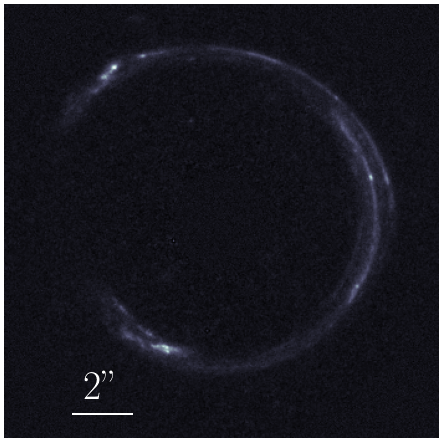

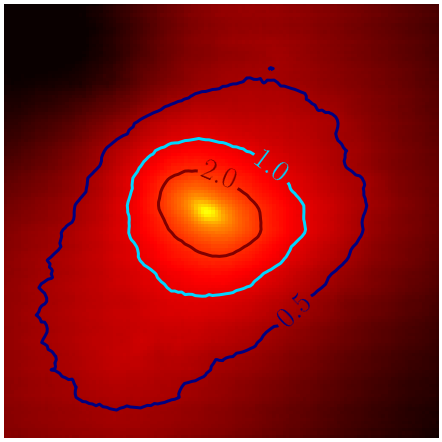

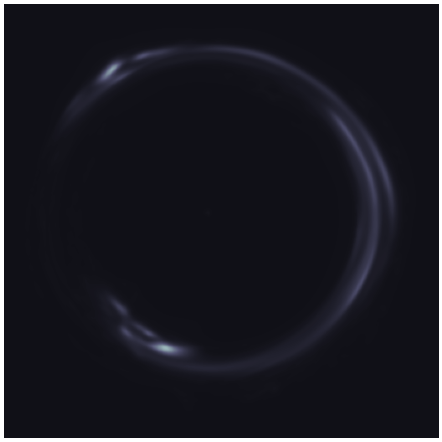

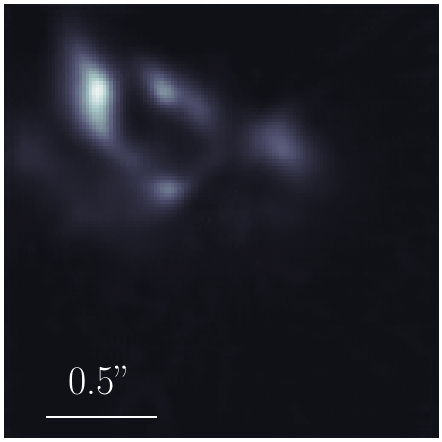

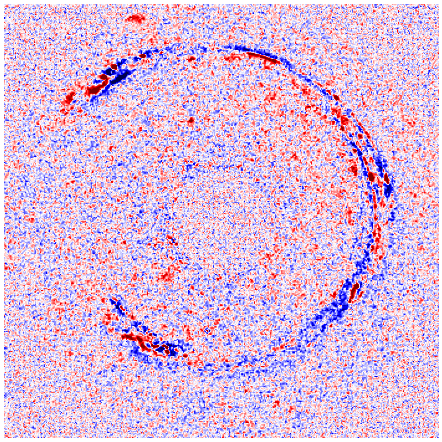

In [21]:
intensity_cmap="bone"
i_norm=ImageNormalize()

plt.figure()
plt.imshow(raw_observation, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch()), origin="lower")
plt.axis("off")
plt.savefig(f"obs_horseshoe_raw.png")

plt.figure()
plt.imshow(observation, cmap=intensity_cmap, norm=i_norm, origin="lower", extent=extent)
plt.axis("off")
p0 = -5
dist = 2
plt.plot([p0, p0 + dist], [-6.5, -6.5], linewidth=2, color="w")
plt.text(p0 + dist / 2., -6, "2''", fontsize=40, color="w", ha='center')
plt.savefig(f"obs_horseshoe.png")

plt.figure()
plt.imshow(np.log10(hf["kappa_best"]), cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower", extent=extent)
levels = [0.5, 1, 2]
cs = plt.contour(kappa_pred, cmap="jet", levels=levels, linewidths=3, extent=extent) # took twice the function 10^x
plt.clabel(cs, levels, fontsize=30)
plt.axis("off")
plt.savefig(f"kappa_pred_horseshoe{src_fov}.png")

plt.figure()
plt.imshow(y_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
plt.axis("off")
plt.savefig(f"obs_pred_horseshoe{src_fov}.png")

plt.figure()
plt.imshow(source_pred, cmap=intensity_cmap, norm=i_norm, origin="lower", extent=extent_src)
p0 = -0.8
dist = 0.5
plt.plot([p0, p0 + dist], [-0.9, -0.9], linewidth=2, color="w")
plt.text(p0 + dist / 2., -0.8, "0.5''", fontsize=40, color="w", ha='center')
plt.axis("off")
plt.savefig(f"source_pred_horseshoe{src_fov}.png")

plt.figure()
# plt.annotate(fr"$\chi^2_\nu =$ {np.sum(((observation - y_pred)/noise_rms)**2 / 350**2):.2f}", xy=(0.3, 0.95), xycoords="axes fraction", size=40, backgroundcolor="w")
plt.imshow((observation - y_pred)/noise_rms, cmap="seismic", vmin=-5, vmax=5, origin="lower")
plt.axis("off")
plt.savefig(f"residual_horseshoe{src_fov}.png")
